Exploring whole-slide images of colon cancer
--
**Obtained dataset**: A pahologhy image set (whole-slide images, aka virtual slides) about the **colon cancer**, whose file extension is '.svs'.<br>

[OpenSlide](https://openslide.org/) is a C library that provides a simple interface for reading whole-slide images, also known as virtual slides, which are high-resolution images used in digital pathology. These images can occupy tens of gigabytes when uncompressed, and so cannot be easily read using standard tools or libraries, which are designed for images that can be comfortably uncompressed into RAM. Whole-slide images are typically multi-resolution; OpenSlide allows reading a small amount of image data at the resolution closest to a desired zoom level.

Some preliminaries
---
**What is an .svs file? What is a tile?** Soure: [Rebecca Stone Blog](https://ysbecca.github.io/programming/2018/05/22/py-wsi.html), whole blog is worth reading!

Essentially, an .svs file is a pyramid of tiled images. OpenSlide has an object called a DeepZoomGenerator which makes this pyramid accessible. Let’s look at an example.

![Label-to-remove](../../misc/svs_pyramid.png)

Most .svs images have between 15-20 levels, depending on the magnification of the image (typically 20x-40x) and the whole slide scanner.

To do:
--
1. **Anonymize patient id**: Each slied contains patient id info, we need to de-identify them.
   - ![Label-to-remove](../../misc/de-identify-label.png)
   <br>
   - [Anonymize-slide](https://github.com/bgilbert/anonymize-slide) is a program to remove the slide label from whole-slide images in the following formats:
      - Aperio SVS
      - Hamamatsu NDPI
      - 3DHISTECH MRXS
    <br>** Slide files are modified in place, making this program both fast and potentially destructive. Do not run it on your only copy of a slide. **<br>
   - [aperio-delete-label.py](https://gist.github.com/malaterre/8019000) Deletes the label image from an Aperio SVS file.
   <br><br>
2. **Export uncompressed image**
   - [py-wsi](https://github.com/ysbecca/py-wsi) provides a series of Python classes and functions which deal with databases of whole slide images (WSI), or Aperio .svs files for machine learning, using Python OpenSlide. py-wsi provides functions to perform patch sampling from .svs files, **generation of metadata**, and several store options: saving to a lightning memory-mapped database (LMDB), HDF5 files, or disk.
   ![Uncompressed-image](../../misc/uncompressed-image.png)
   <br>
   - [deep-openslide](https://github.com/shaziaakbar/deep-openslide) is a library for extracting patches whole-slide images.
     - extract.py provides functionality for extracting patches from pathology slides using openslide. Slides should be provided as .svs files and the location to these files is determined when you set up an instance of the TissueLocator class.
   <br><br>
3. **TBD**
   - None

In [1]:
import numpy as np # package for scientific computing and linear algebra

from matplotlib import pyplot as plt # plotting library
# show the image within the cell of the current notebook
%matplotlib inline

import extract # Package for Extracting patches from whole-slide images (taken from deep-openslide)
import h5py # Datastore for extracted patches

import glob # package for OS utility, e.g., listing all the files of a directory with a given criteria

/home/a_khanss/anaconda3/envs/med-img/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Sample .svs file
svs_file = '/home/data/med-img/colon-cancer/wsi_svs/CMU-1-JP2K-33005_anon.svs'

In [3]:
# location for h5 files where we'll save the patches
patch_location = '/home/data/med-img/colon-cancer/extracted_patches/'

In [4]:
# 'TissueLocator' constructor in extract.py: location of the slide to be processed
# and the size of the tiles to extract (i.e. tile_size) with three different modes ("all", "random", "mask")
einst = extract.TissueLocator(svs_file, tile_size = (512, 512), mode="all")

In [5]:
# list the patch files
list_patch_files = glob.glob(patch_location + "/*.h5")
len(list_patch_files)

13

In [6]:
# store the patches externally. By default .h5 files are generated 
if len(list_patch_files) == 0:
    einst.extract_patches_and_save(out_location = patch_location, workers=4)

In [14]:
# Sanity check: Number of patches if we tiles (512 x 512) crop in this sample file
num_patches = 0
for i in range(len(list_patch_files)):
    patch_file = list_patch_files[i]
    meta = h5py.File(patch_file, 'r')
    patches = meta['x'][:]
    meta.close()
    num_patches += len(patches)
print(num_patches)

5696


In [7]:
# read random tiles
np.random.seed(0)
patch_file = list_patch_files[np.random.randint(len(list_patch_files))] # choose a random file
meta = h5py.File(patch_file, 'r')
patches = meta['x'][:]
meta.close()

In [8]:
len(patches)

516

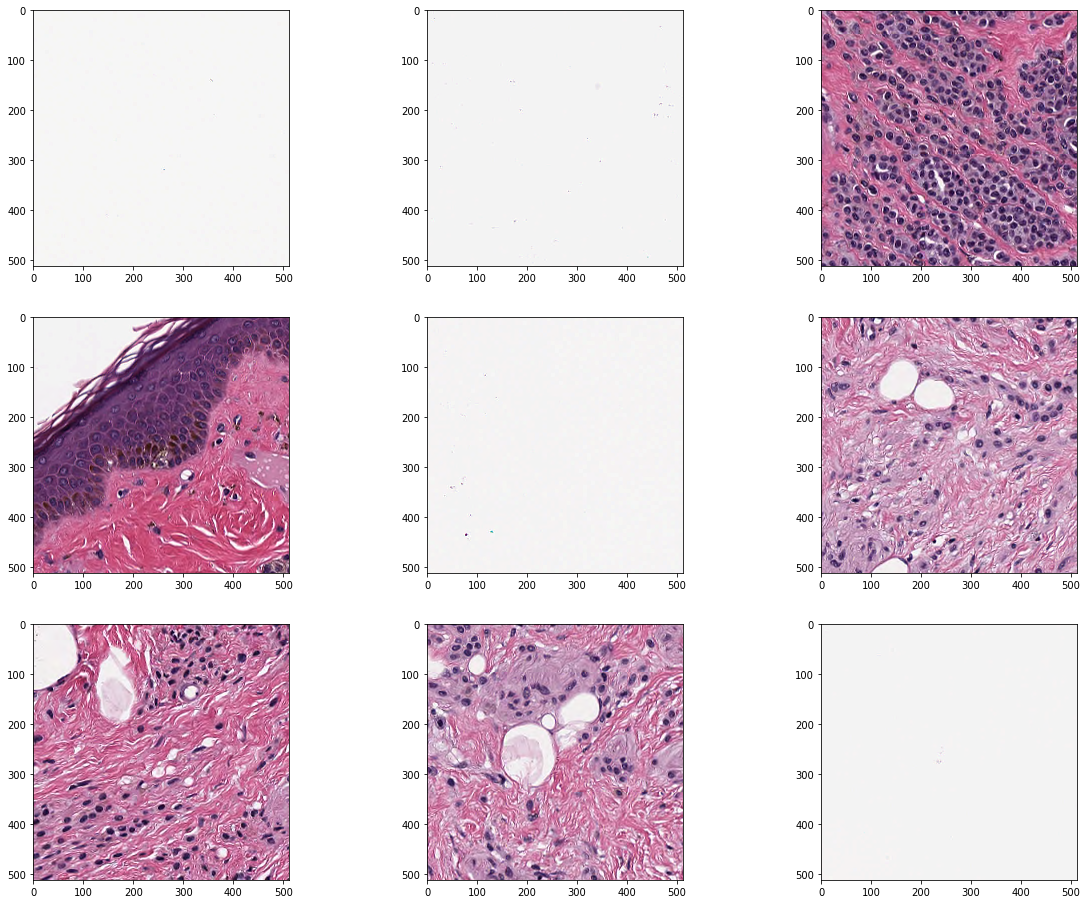

In [9]:
# Show some random patches
fig = plt.figure(figsize=(20, 16))

np.random.seed(0)
idx = np.random.randint(0, len(patches), 9) # selecting 9 random index of patches

for i in range(9):
    data = np.transpose(patches[idx[i]], [1, 2, 0]) # Making 'RGB' channel as a 3rd dimension for matplotlib
    plt.subplot(330 + (i+1))
    plt.imshow(data, interpolation='nearest')

plt.show()

**Some primary notes**
- Image dimension of the sample image is (46000, 32893), total size of the patches for this single image is ~17GB
- Extracting regions containing tissue only may reduce the size!
- Google paper handles gigapixel microscopy images sized 100,000 × 100,000 pixels
- Seems that we'll need to handle sheer amount of data for our model!

Extracting regions containing tissue only
--
- **TBD**: Perhaps, we may extract regions containing tissue only for our model

In [10]:
# location for h5 files where we'll save the patches
patch_location = '/home/data/med-img/colon-cancer/extracted_patches_tissue_only/'

In [11]:
'''
einst = extract.TissueLocator(svs_file, tile_size = (512, 512), mode="all", use_tissue_finder=True)
extracted_points = einst.get_coordinates_as_list(dims=(512, 512))

einst.extract_patches_and_save(out_location = patch_location, workers=4, list_points=extracted_points)
'''

'\neinst = extract.TissueLocator(svs_file, tile_size = (512, 512), mode="all", use_tissue_finder=True)\nextracted_points = einst.get_coordinates_as_list(dims=(512, 512))\n\neinst.extract_patches_and_save(out_location = patch_location, workers=4, list_points=extracted_points)\n'

In [12]:
# extracted_points